We use a physiological interpretation of consonance and dissonant musical sound for human listeners and use a dissonance score to rate different possible triads (combinations of three notes in a scale). This is first done on the conventional scale of 12 equidistant tones in an octave, as well as the Bohlen-Pierce scale.

In [1]:
using Plots
gr()

Plots.GRBackend()

## Plomp-Levelt dissonance curve

As a basis of our investigation, we use the Plomp-Levelt dissonance curve as explained in [this article](http://sethares.engr.wisc.edu/consemi.html) by William Sethares.

The curve models the fact that similar frequencies appear dissonant because of "friction" between the adjacent sensors in our ears.

In [2]:
"Dissonance of sound with two sinusoidal sounds with given frequencies and amplitudes."
function diss(freq1, ampl1, freq2, ampl2)
    if freq2 < freq1 # swap args
        return diss(freq2, ampl2, freq1, ampl1)
    end
    s = 0.24 * (freq2 - freq1) / (0.0207 * freq1 + 18.96)
    5.0 * ampl1 * ampl2 * (exp(-3.51 * s) - exp(-5.75 * s))
end

diss

Let's draw the curve for a pair of sine waves, the first fixed at given base frequency and the other going through a range of relatively higher frequencies.

In [3]:
basefreq = 440.0
ratrange = range(1.0, stop=3.0, length=200)
otherfreq = basefreq * ratrange
disss = diss.(basefreq, 1.0, otherfreq, 1.0);

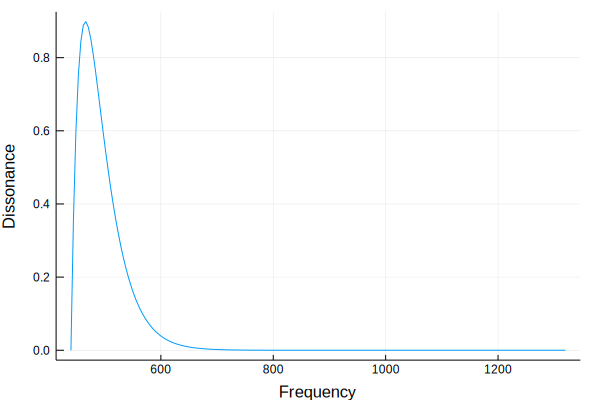

In [4]:
plot(otherfreq, disss, xlabel="Frequency", ylabel="Dissonance", legend=false)

## Dissonance with harmonics

Rather than analyzing dissonance between sinusoidal sounds, we also want to consider sounds with rich harmonics. These have sounds at multiple frequencies with declining amplitudes. When computing the dissonance between two pitches with harmonics, we have to add the dissonance values for all combinations of frequencies.

In [5]:
# Let's first give formulas for the amplitudes of common waveshapes.

enumrange(number::Int) = collect(range(1.0, stop=number, length=number))

abstract type Wave end

struct Sine <: Wave end
harm(::Sine, number::Int) = vcat([1.0], zeros(number - 1))

struct Sawtooth <: Wave end
harm(::Sawtooth, number::Int) = 1.0 ./ enumrange(number)

struct Triangle <: Wave end
harm(::Triangle, number::Int) = [(((i+2)%4)-2)*(i%2) for i=1:number] ./ enumrange(number).^2

struct Square <: Wave end
harm(::Square, number::Int) = [i%2 for i in 1:number] ./ enumrange(number)


harm (generic function with 4 methods)

In [6]:
@show harm(Sine(), 9)
@show harm(Sawtooth(), 9)
@show harm(Square(), 9)
@show harm(Triangle(), 9);

harm(Sine(), 9) = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
harm(Sawtooth(), 9) = [1.0, 0.5, 0.333333, 0.25, 0.2, 0.166667, 0.142857, 0.125, 0.111111]
harm(Square(), 9) = [1.0, 0.0, 0.333333, 0.0, 0.2, 0.0, 0.142857, 0.0, 0.111111]
harm(Triangle(), 9) = [1.0, 0.0, -0.111111, 0.0, 0.04, 0.0, -0.0204082, 0.0, 0.0123457]


Let's also quickly check how our approximated waveforms look:

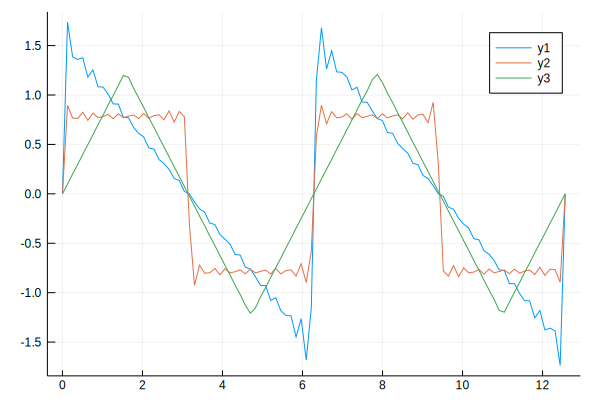

In [7]:
xx = range(0, stop=4π, length=100)

function yy(wave, n)
    coefs = harm(wave, n)
    sum(coefs[f] * sin.(f*xx) for f=1:n)
end

plot(xx,[yy(w, 20) for w in [Sawtooth(), Square(), Triangle()]])

In [8]:
# We add a new type to couple frequency and amplitute of a harmonic overtone

struct Tone
    freq::Float64
    ampl::Float64
end

diss(t1::Tone, t2::Tone) = diss(t1.freq, t1.ampl, t2.freq, t2.ampl)

diss (generic function with 2 methods)

In [9]:
# More functions to generate all overtones

function harmonics(wave::Wave, basefreq::Float64, number::Int)
    # frequencies with integer multiples
    freqs = basefreq .* enumrange(number)
    ampls = abs.(harm(wave, number))
    # keep tones with nonzero amplitude
    [Tone(tup...) for tup in zip(freqs, ampls) if tup[2] > 0.0]
end

harmonics (generic function with 1 method)

In [10]:
@show harmonics(Sine(), 440.0, 4)
@show harmonics(Triangle(), 440.0, 4);

harmonics(Sine(), 440.0, 4) = Tone[Tone(440.0, 1.0)]
harmonics(Triangle(), 440.0, 4) = Tone[Tone(440.0, 1.0), Tone(1320.0, 0.111111)]


In [11]:
function diss(tones::AbstractArray{Tone})
    res = 0.0
    # iterate over all pairs
    n = length(tones)
    for i = 1:n
        for j=i+1:n
            res += diss(tones[i], tones[j])
        end
    end
    res
end

diss (generic function with 3 methods)

In [12]:
function together(tones1::AbstractArray{Tone}, tones2::AbstractArray{Tone})
    # TODO: should do proper merge and match those tones with same frequency?
    vcat(tones1, tones2)
end

function diss(tones1::AbstractArray{Tone}, tones2::AbstractArray{Tone})
    diss(together(tones1, tones2))
end

diss (generic function with 4 methods)

As a first example, we look at the square waveform approximated with 10 harmonices and draw the dissonance curve for two pitches played simultaneously.

Note the local maxima near frequency rations 1 and 2 and the minima at integer (or "simple") ratios.

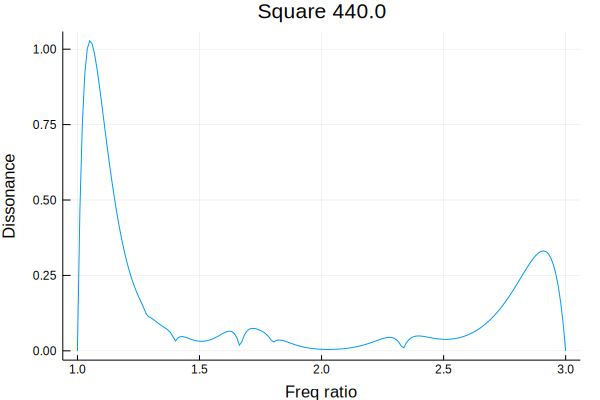

In [13]:
numharm = 10
basetone = harmonics(Square(), basefreq, numharm)
othertones = [harmonics(Square(), of, numharm) for of in otherfreq]
disss = [diss(basetone, ot) for ot in othertones]

plot(ratrange, disss, legend=false, xlabel="Freq ratio", ylabel="Dissonance", title="Square $basefreq")

Next, we repeat the experiment, now based on an approximation of the sawtooth waveform.
Because of the richer harmonices, there is more interaction and more dissonance (in absolute terms).

As a consequence, the dissonance curve shows more local minima, again corresponding to "simple" frequency ratios, that is, ratios of small integers. 

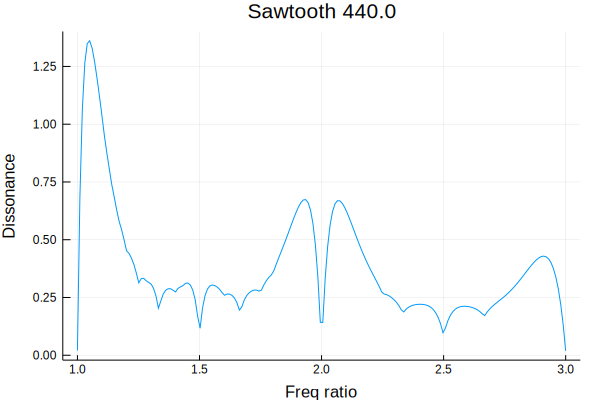

In [14]:
numharm = 10
basetone = harmonics(Sawtooth(), basefreq, numharm)
othertones = [harmonics(Sawtooth(), of, numharm) for of in otherfreq]
disss = [diss(basetone, ot) for ot in othertones]

plot(ratrange, disss, legend=false, xlabel="Freq ratio", ylabel="Dissonance", title="Sawtooth $basefreq")

## Triads

We will now compute the dissonaces for triads of tones in an analoguous fashion.
But this time, we will only evaluate a discrete set of pitches, based on a 12-tone scale, dividing the octave in equal steps.

In [15]:
# dissonance for triads
function diss(tones1::AbstractArray{Tone}, tones2::AbstractArray{Tone}, tones3::AbstractArray{Tone})
    diss(together(together(tones1, tones2), tones3))
end

diss (generic function with 5 methods)

In [16]:
# range of one octave
halfstep = 2.0^(1.0/12.0)
@show halfstep
ratrange = [halfstep^i for i=0:12]

basefreq = 440.0
otherfreq = basefreq * ratrange;

halfstep = 1.0594630943592953


We start using the square waveform. In the heatmap below, we can see that dissonance is high whenever a single halfstep is present in the triad. This is true for the horizontal and vertical lines that are off by one from the origin, as well as the two diagonals off by one from the center. To a lesser extent, this pattern repeats for 11 halfsteps (one octave up, one halfstep down).

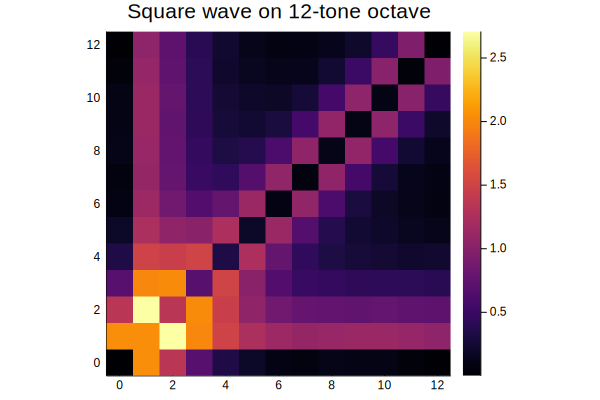

In [17]:
# start with square wave again
numharm = 10
basetone = harmonics(Square(), basefreq, numharm)
othertones = [harmonics(Square(), of, numharm) for of in otherfreq]

# compute dissonances of all triads
disss = [diss(basetone, ot1, ot2) for ot1 in othertones, ot2 in othertones]

heatmap(0:12, 0:12, disss, aspect_ratio=1.0, title="Square wave on 12-tone octave")

If we use the sawtooth wave instead, we see a richer structure in the dissonance heatmap.
Here, we should also be able to recognize familiar concepts such as the major or minor triads.

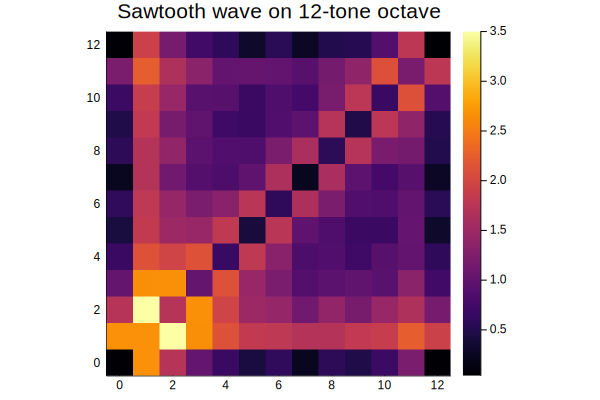

In [18]:
# now use richer sawtooth wave
numharm = 10
basetone = harmonics(Sawtooth(), basefreq, numharm)
othertones = [harmonics(Sawtooth(), of, numharm) for of in otherfreq]

# compute dissonances of all triads
disss = [diss(basetone, ot1, ot2) for ot1 in othertones, ot2 in othertones]

heatmap(0:12, 0:12, disss, aspect_ratio=1.0, title="Sawtooth wave on 12-tone octave")

## Bohlen-Pierce Scale

One way to view the conventional western scale is as a division of an octave (that is, a 2:1 ratio of frequency) in 12 (more or less) equal steps. Alternatively, one can start at the ratios 4:5:6 (appearing naturally as harmonics) and collect pitches that are reached from these recursively.

In the [Bohlen-Pierce](http://www.huygens-fokker.org/bpsite/) scale, we range over a tritave (a 3:1 ratio) in 13 steps. This can also be derived using ratios 3:5:7. The scale is well-suited for instruments that only feature [odd harmonics](https://www.soundonsound.com/techniques/synthesizing-pan-pipes), such as the [clarinet](https://en.wikipedia.org/wiki/Clarinet#Acoustics) or the [pan flute](http://bohlen-pierce-conference.org/bohlen-pierce-instruments/pan-flute).

In [19]:
# range of one tritave
bpstep = 3.0^(1.0/13.0)
@show bpstep
ratrange = [bpstep^i for i=0:13]

basefreq = 440.0
otherfreq = basefreq * ratrange;

bpstep = 1.0881822434633168


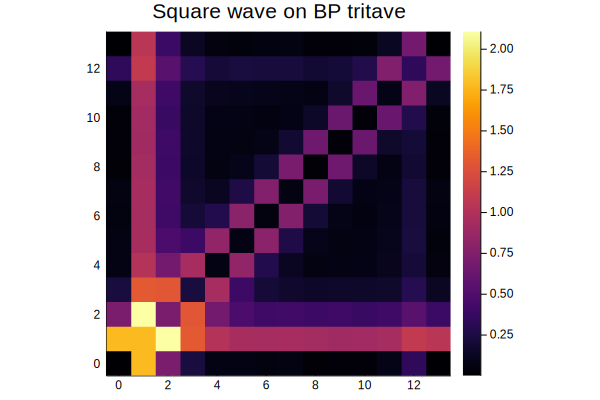

In [20]:
# start with square wave again
numharm = 10
basetone = harmonics(Square(), basefreq, numharm)
othertones = [harmonics(Square(), of, numharm) for of in otherfreq]

# compute dissonances of all triads
disss = [diss(basetone, ot1, ot2) for ot1 in othertones, ot2 in othertones]

heatmap(0:13, 0:13, disss, aspect_ratio=1.0, title="Square wave on BP tritave")

The heatmap above looks fairly boring, with not much dissonance apart from the obvious lines. Maybe this is related to the wider spacing of the steps in this scale.

We will also look at the sawtooth wave, even though we should expect high dissonance through-out.

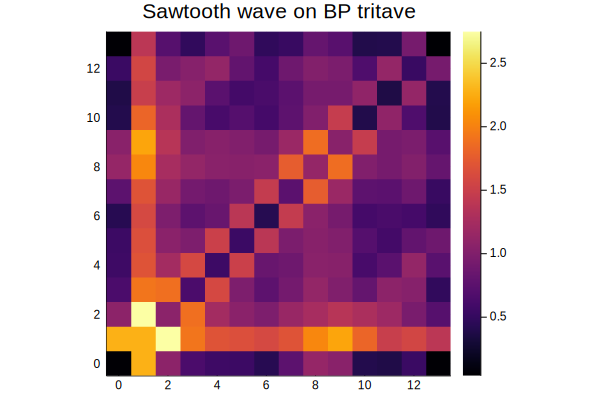

In [21]:
# now use richer sawtooth wave
numharm = 10
basetone = harmonics(Sawtooth(), basefreq, numharm)
othertones = [harmonics(Sawtooth(), of, numharm) for of in otherfreq]

# compute dissonances of all triads
disss = [diss(basetone, ot1, ot2) for ot1 in othertones, ot2 in othertones]

heatmap(0:13, 0:13, disss, aspect_ratio=1.0, title="Sawtooth wave on BP tritave")

## Larger Pitch Ranges

We will generate some more heatmaps covering two octaves or tritaves, each time based on sawtooth waves.

First the 12-tone octaves:

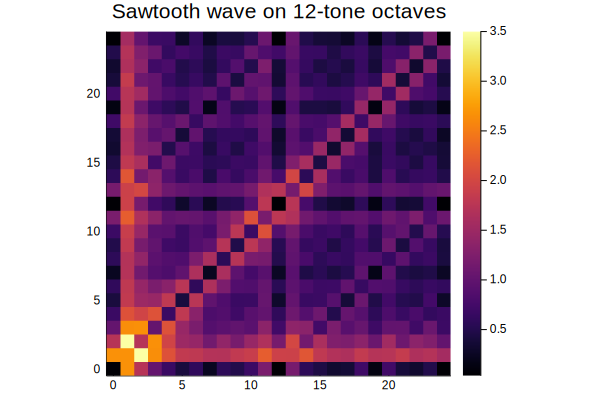

In [22]:
# range of two octaves
ratrange = [halfstep^i for i=0:24]
basefreq = 440.0
otherfreq = basefreq * ratrange

# sawtooth wave
numharm = 10
basetone = harmonics(Sawtooth(), basefreq, numharm)
othertones = [harmonics(Sawtooth(), of, numharm) for of in otherfreq]

# compute dissonances of all triads
disss = [diss(basetone, ot1, ot2) for ot1 in othertones, ot2 in othertones]

heatmap(0:24, 0:24, disss, aspect_ratio=1.0, title="Sawtooth wave on 12-tone octaves")

Then the BP tritaves:

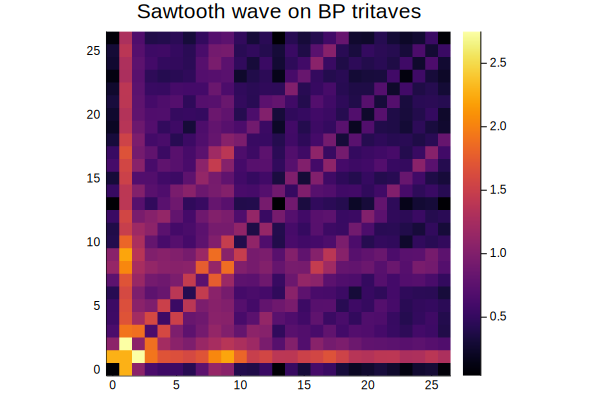

In [23]:
# range of two tritaves
ratrange = [bpstep^i for i=0:26]
basefreq = 440.0
otherfreq = basefreq * ratrange

# sawtooth wave
numharm = 10
basetone = harmonics(Sawtooth(), basefreq, numharm)
othertones = [harmonics(Sawtooth(), of, numharm) for of in otherfreq]

# compute dissonances of all triads
disss = [diss(basetone, ot1, ot2) for ot1 in othertones, ot2 in othertones]

heatmap(0:26, 0:26, disss, aspect_ratio=1.0, title="Sawtooth wave on BP tritaves")